In [4]:
import pandas as pd
import h5py
import numpy as np
import scipy as sp
import scipy.signal as sg
import xarray as xr
import os
import matplotlib.pyplot as plt
from matplotlib import patches
import ast

%matplotlib notebook

In [5]:
main_path = [
    r"\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\Task 2 pilot\2022-08-15_11-22-28_626791\processed",
    r"\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\Task 2 pilot\2022-08-16_12-43-07_626791\processed",
    r"\\allen\programs\mindscope\workgroups\dynamicrouting\PilotEphys\Task 2 pilot\2022-08-17_13-25-06_626791\processed"
]

In [8]:
# make a function to loop through main paths, create an experiment object for each exp

class Session:
    
    def __init__(self,params=None,path=None):
        
        #load trials
        self.trials=pd.read_csv(os.path.join(path,'trials_table.csv'))
        trial_stim_dur=np.zeros(len(self.trials))
        for tt in range(0,len(self.trials)):
            if self.trials['trial_sound_dur'].iloc[tt]>0:
                trial_stim_dur[tt]=self.trials['trial_sound_dur'].iloc[tt]
            elif self.trials['trial_vis_stim_dur'].iloc[tt]>0:
                trial_stim_dur[tt]=self.trials['trial_vis_stim_dur'].iloc[tt]

        self.trials['trial_stim_dur']=trial_stim_dur
        
        #load lick times
        self.lick_times=np.load(os.path.join(path,'lick_times.npy'),allow_pickle=True)
        self.lick_times=self.lick_times[0]
        
        #load units
        self.units=pd.read_csv(os.path.join(path,'unit_table.csv'))
        self.units=self.units.set_index('id')
        self.good_units=self.units.query('quality == "good" and \
                        isi_viol < 0.5 and \
                        amplitude_cutoff < 0.1 and \
                        presence_ratio > 0.95')
        self.good_units=self.good_units.sort_values(by=['probe','peak_channel'])
        
        #load spike times
        self.spike_times=np.load(os.path.join(path,'spike_times_aligned.npy'),allow_pickle=True).item()
        
        #load frames
        self.frames=pd.read_csv(os.path.join(path,'frames_table.csv'))
        


In [9]:
sessions={}

for mi,mm in enumerate(main_path):
    sessions[mi]=Session(path=mm)
    

In [14]:
sessions[0].trials

,Unnamed: 0,trialStartFrame,trialStimID,trialstimRewarded,trial_response,trial_sound_dur,trial_vis_stim_dur,vis_go_trials,vis_nogo_trials,vis_hit_trials,...,aud_false_alarm_trials,aud_miss_trials,aud_correct_reject_trials,aud_autoreward_trials,catch_trials,catch_resp_trials,trialStimStartFrame,stimStartTime,stimLatency,trial_stim_dur
0,0,0,vis1,vis1,True,0.0,0.5,True,False,False,...,False,False,False,False,False,False,433,87.284220,0.020720,0.5
1,1,674,vis1,vis1,True,0.0,0.5,True,False,False,...,False,False,False,False,False,False,803,93.456000,0.020720,0.5
2,2,1044,vis1,vis1,True,0.0,0.5,True,False,False,...,False,False,False,False,False,False,1197,100.030075,0.022585,0.5
3,3,1438,vis1,vis1,True,0.0,0.5,True,False,False,...,False,False,False,False,False,False,1600,106.752255,0.022585,0.5
4,4,1841,vis1,vis1,True,0.0,0.5,True,False,False,...,False,False,False,False,False,False,1993,113.307625,0.022345,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
474,474,213238,sound2,sound1,True,0.5,0.0,False,False,False,...,True,False,False,False,False,False,213351,3639.015000,0.105250,0.5
475,475,213592,vis2,sound1,False,0.0,0.5,False,True,False,...,False,False,False,False,False,False,214200,3653.094225,0.022725,0.5
476,476,214441,sound1,sound1,True,0.5,0.0,False,False,False,...,False,False,False,False,False,False,214582,3659.535086,0.091646,0.5
477,477,214823,vis1,sound1,False,0.0,0.5,True,False,False,...,False,False,False,False,False,False,215388,3672.910360,0.022480,0.5


In [16]:
def makePSTH(spikes, startTimes, windowDur, binSize=0.001):
    '''
    Convenience function to compute a peri-stimulus-time histogram
    (see section 7.2.2 here: https://neuronaldynamics.epfl.ch/online/Ch7.S2.html)
    INPUTS:
        spikes: spike times in seconds for one unit
        startTimes: trial start times in seconds; the first spike count 
            bin will be aligned to these times
        windowDur: trial duration in seconds
        binSize: size of spike count bins in seconds
    OUTPUTS:
        Tuple of (PSTH, bins), where:
            PSTH gives the trial-averaged spike rate for 
                each time bin aligned to the start times;
            bins are the bin edges as defined by numpy histogram
    '''
    bins = np.arange(0,windowDur+binSize,binSize)
    counts = np.zeros(bins.size-1)
    for i,start in enumerate(startTimes):
        startInd = np.searchsorted(spikes, start)
        endInd = np.searchsorted(spikes, start+windowDur)
        counts = counts + np.histogram(spikes[startInd:endInd]-start, bins)[0]
    
    counts = counts/len(startTimes)
    return counts/binSize, bins


def make_neuron_time_trials_tensor(units, spike_times, stim_table, 
                                   time_before, trial_duration,
                                   bin_size=0.001):
    '''
    Function to make a tensor with dimensions [neurons, time bins, trials] to store
    the spike counts for stimulus presentation trials. 
    INPUTS:
        units: dataframe with unit info (same form as session.units table)
        stim_table: dataframe whose indices are trial ids and containing a
            'start_time' column indicating when each trial began
        time_before: seconds to take before each start_time in the stim_table
        trial_duration: total time in seconds to take for each trial
        bin_size: bin_size in seconds used to bin spike counts 
    OUTPUTS:
        unit_tensor: tensor storing spike counts. The value in [i,j,k] 
            is the spike count for neuron i at time bin j in the kth trial.
    '''
    neuron_number = len(units)
    trial_number = len(stim_table)
    unit_tensor = np.zeros((neuron_number, int(trial_duration/bin_size), trial_number))
    
    for u_counter, (iu, unit) in enumerate(units.iterrows()):
        unit_spike_times = spike_times[iu]
        for t_counter, (it, trial) in enumerate(stim_table.iterrows()):
            if 'stimStartTime' in trial:
                trial_start = trial.stimStartTime - time_before
            elif 'start_time' in trial:
                trial_start = trial.start_time - time_before
            unit_tensor[u_counter, :, t_counter] = makePSTH(unit_spike_times, 
                                                            [trial_start], 
                                                            trial_duration, 
                                                            binSize=bin_size)[0]
    return unit_tensor

In [21]:
# loop through sessions and make unit xarrays
time_before_flash = 1
trial_duration = 3
bin_size = 0.001


for ss in sessions:
    #Make tensor
    trial_tensor = make_neuron_time_trials_tensor(sessions[ss].good_units, sessions[ss].spike_times, 
                                                  sessions[ss].trials,time_before_flash, trial_duration, 
                                                  bin_size)

    # make xarray
    sessions[ss].trial_da = xr.DataArray(trial_tensor, dims=("unit_id", "time", "trials"), 
                               coords={
                                   "unit_id": sessions[ss].good_units.index.values,
                                   "time": np.arange(0, trial_duration, bin_size)-time_before_flash,
                                   "trials": sessions[ss].trials.index.values
                                   })

In [22]:
sessions[0].trial_da

<xarray.DataArray (unit_id: 653, time: 3000, trials: 479)>
array([[[   0.,    0.,    0., ...,    0.,    0.,    0.],
        [   0.,    0.,    0., ...,    0., 1000.,    0.],
        [   0.,    0.,    0., ...,    0.,    0.,    0.],
        ...,
        [   0.,    0.,    0., ...,    0.,    0.,    0.],
        [   0.,    0.,    0., ...,    0.,    0.,    0.],
        [   0.,    0.,    0., ...,    0.,    0.,    0.]],

       [[   0.,    0.,    0., ...,    0.,    0.,    0.],
        [   0.,    0.,    0., ...,    0.,    0.,    0.],
        [   0.,    0.,    0., ...,    0.,    0.,    0.],
        ...,
        [   0.,    0.,    0., ...,    0.,    0.,    0.],
        [   0.,    0.,    0., ...,    0.,    0.,    0.],
        [   0.,    0.,    0., ...,    0.,    0.,    0.]],

       [[   0.,    0.,    0., ...,    0.,    0., 1000.],
        [   0.,    0.,    0., ...,    0.,    0.,    0.],
        [   0.,    0.,    0., ...,    0.,    0.,    0.],
        ...,
        [   0.,    0.,    0., ...,    0.,    0.,    0.],
        [   0.,    0.,    0., ...,    0.,    0.,    0.],
        [   0.,    0.,    0., ...,    0.,    0.,    0.]],

       ...,

       [[   0.,    0.,    0., ...,    0.,    0.,    0.],
        [   0.,    0.,    0., ..., 1000.,    0.,    0.],
        [   0.,    0., 1000., ...,    0.,    0.,    0.],
        ...,
        [   0.,    0.,    0., ...,    0.,    0.,    0.],
        [   0.,    0.,    0., ...,    0.,    0.,    0.],
        [   0.,    0.,    0., ...,    0.,    0.,    0.]],

       [[   0.,    0.,    0., ...,    0.,    0.,    0.],
        [   0.,    0.,    0., ...,    0.,    0.,    0.],
        [   0.,    0.,    0., ...,    0., 1000.,    0.],
        ...,
        [   0.,    0.,    0., ...,    0.,    0.,    0.],
        [   0.,    0.,    0., ...,    0.,    0.,    0.],
        [   0.,    0.,    0., ...,    0.,    0.,    0.]],

       [[   0.,    0.,    0., ...,    0.,    0.,    0.],
        [   0.,    0.,    0., ...,    0.,    0.,    0.],
        [   0.,    0.,    0., ...,    0.,    0.,    0.],
        ...,
        [   0.,    0.,    0., ...,    0.,    0.,    0.],
        [   0.,    0.,    0., ...,    0.,    0.,    0.],
        [   0.,    0.,    0., ...,    0.,    0.,    0.]]])
Coordinates:
  * unit_id  (unit_id) int64 10002 10004 10006 10011 ... 60442 60443 60445 60449
  * time     (time) float64 -1.0 -0.999 -0.998 -0.997 ... 1.997 1.998 1.999
  * trials   (trials) int64 0 1 2 3 4 5 6 7 ... 471 472 473 474 475 476 477 478

<IPython.core.display.Javascript object>


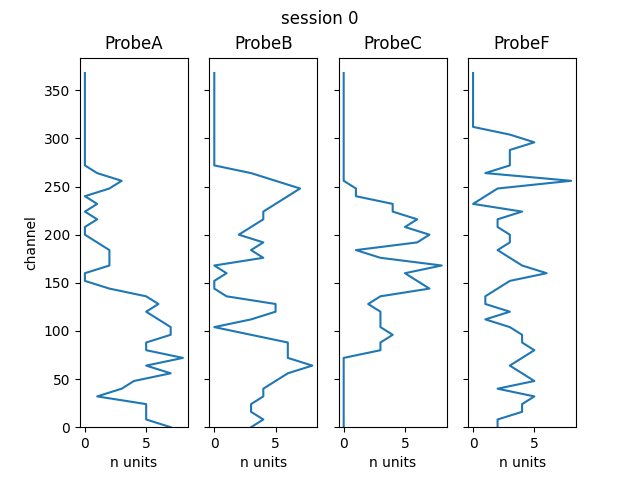

<IPython.core.display.Javascript object>


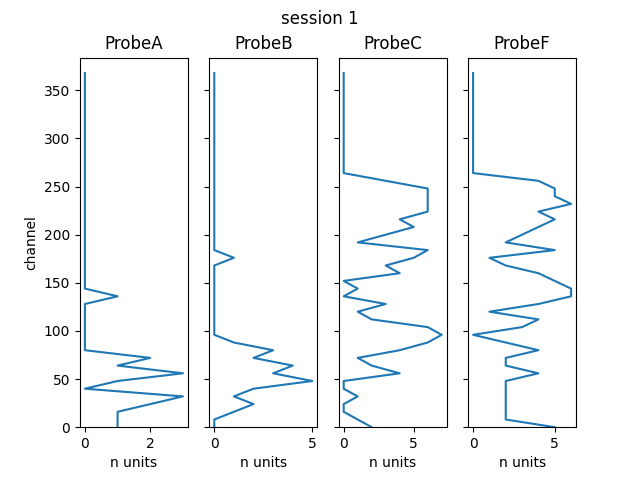

<IPython.core.display.Javascript object>


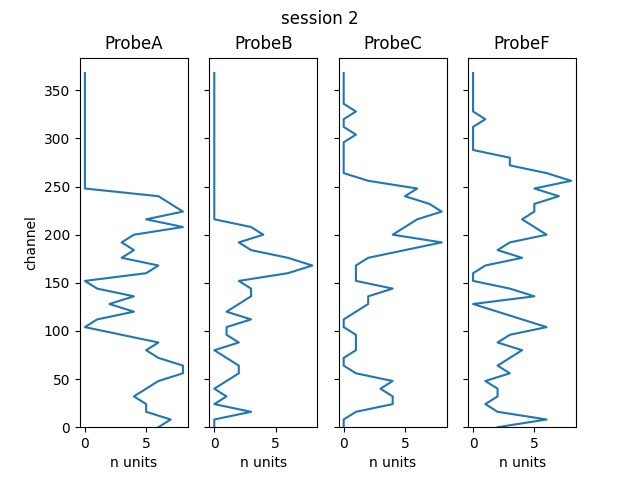

In [24]:
# ID areas
for ss in sessions:

    probes = sessions[ss].good_units['probe'].unique()
    ch_bins=np.arange(0,384,8)

    units_by_channel = sessions[ss].good_units[['probe','peak_channel']].value_counts()

    fig,ax=plt.subplots(1,len(probes))

    for ip,pr in enumerate(probes):
        unit_hist,edges=np.histogram(units_by_channel[pr].sort_index().index,bins=ch_bins)
        ax[ip].plot(unit_hist,ch_bins[:-1])
    #     ax[ip].plot(units_by_channel[pr].sort_index().values,units_by_channel[pr].sort_index().index)
        ax[ip].set_ylim([0,384])
        ax[ip].set_xlabel('n units')
        ax[ip].set_title('Probe'+pr)
        if ip>0:
            ax[ip].set_yticklabels([])
        else:
            ax[ip].set_ylabel('channel')
        
    fig.suptitle('session '+ str(ss))
        

In [27]:
## make probe-by-probe dicts
channel_data={}

for ss in sessions:

    n_chans_to_average = 8
    chan_vect = np.arange(0,384,n_chans_to_average)
    baseline_time = [-0.07,-0.02]
    stim_time = [0.02, 0.07]

    trial_type_dict = ['vis_go_trials','vis_nogo_trials','aud_go_trials','aud_nogo_trials','catch_trials']
    probe_dict = ['A','B','C','F']

    #save [probe][trial_type] dicts of channel vectors?

    line_styles = ['b-','b--','r-','r--','grey']
    line_style = {}

    channel_data[ss]={}
    for pr in probe_dict:
        channel_data[ss][pr]={}
        for it,tt in enumerate(trial_type_dict):
            channel_data[ss][pr][tt]=np.zeros(len(chan_vect))
            line_style[tt]=line_styles[it]

    for ip,probe in enumerate(probe_dict):
        for tt,trial_type in enumerate(trial_type_dict):
            for cc,ch in enumerate(chan_vect):
                #find units in channel range
                sel_units = sessions[ss].good_units.query(
                    "peak_channel >= @ch and \
                    peak_channel < @ch+@n_chans_to_average and \
                    probe == @probe")
                unit_ch_idx = sel_units.index.values

                #find avg baseline fr of these units during these trials
                baseline_data = sessions[ss].trial_da.sel(
                    trials=sessions[ss].trials[sessions[ss].trials[trial_type]==True].index.values,                    
                    unit_id=unit_ch_idx,                      
                    time=slice(baseline_time[0],baseline_time[1]))

                #find avg stim fr of these units during these trials
                stimulus_data = sessions[ss].trial_da.sel(
                    trials=sessions[ss].trials[sessions[ss].trials[trial_type]==True].index.values,
                    unit_id=unit_ch_idx,
                    time=slice(stim_time[0],stim_time[1]))

                channel_data[ss][probe][trial_type][cc]=np.abs(stimulus_data.mean()-baseline_data.mean())




C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_3

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_3

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_3

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_3

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_3

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_3

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_3

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_3

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_3

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_3

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_3

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_3

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_3

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_3

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_3

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_3

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_3

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_3

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_3

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_3

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_3

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_3

C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_38_new\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
C:\Anaconda3\envs\allensdk_3

<IPython.core.display.Javascript object>


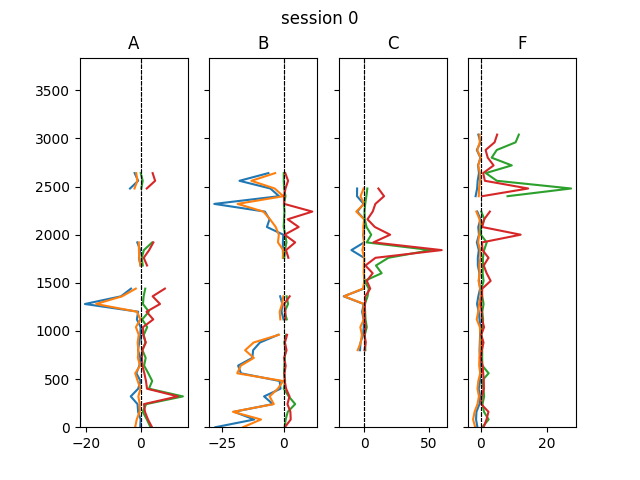

<IPython.core.display.Javascript object>


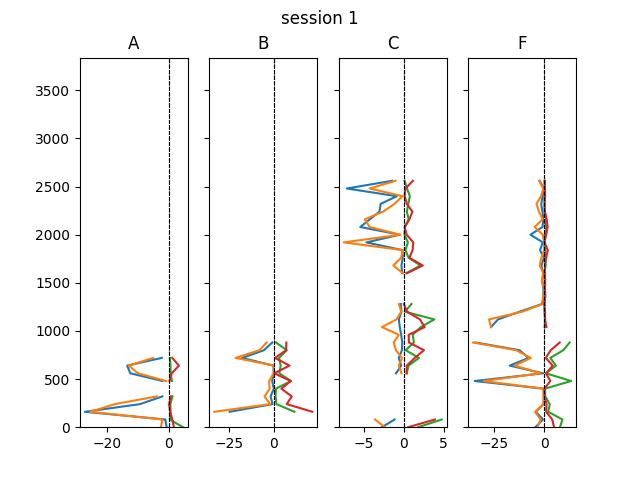

<IPython.core.display.Javascript object>


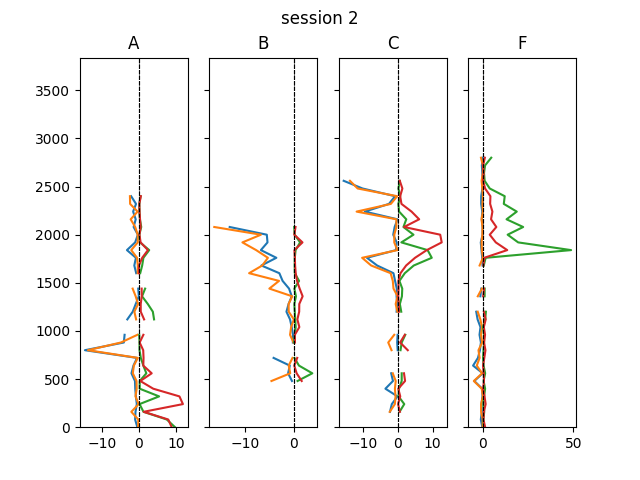

In [28]:
# plot the channel-wise data
for ss in sessions:

    fig, ax = plt.subplots(1,len(probe_dict),sharey=True)

    for ip,probe in enumerate(probe_dict):
        for tt,trial_type in enumerate(trial_type_dict):
            ax[ip].axvline(0,linestyle='--',color='k',linewidth=0.75)
            if 'vis' in trial_type:
                ax[ip].plot(-channel_data[ss][probe][trial_type],chan_vect*10)
            elif 'aud' in trial_type:
                ax[ip].plot(channel_data[ss][probe][trial_type],chan_vect*10)

    #     if ip>0:
    #         ax[ip].set_yticklabels([])

        ax[ip].set_title(probe)

        ax[ip].set_ylim([0,3840])
        
        fig.suptitle('session '+ str(ss))
    #     ax[ip].set_xlim([-40,40])

In [52]:
#area guesses - 8/15 recording
area_ch_guess={}

area_ch_guess[0]={}
area_ch_guess[1]={}
area_ch_guess[2]={}

#rec0
area_ch_guess[0]['A']={}
area_ch_guess[0]['A']['RSP']=[200,280]
area_ch_guess[0]['A']['Hipp']=[150,200]
area_ch_guess[0]['A']['VIS_Thal']=[120,150]
area_ch_guess[0]['A']['Thal']=[0,120]

area_ch_guess[0]['B']={}
area_ch_guess[0]['B']['VIS']=[200,280]
area_ch_guess[0]['B']['Hipp']=[100,200]
area_ch_guess[0]['B']['VIS_Thal']=[0,100]

area_ch_guess[0]['C']={}
area_ch_guess[0]['C']['VISl']=[215,260]
area_ch_guess[0]['C']['AUD']=[150,215]
area_ch_guess[0]['C']['Hipp']=[50,150]

area_ch_guess[0]['F']={}
area_ch_guess[0]['F']['MOs']=[235,325]
area_ch_guess[0]['F']['STR']=[0,235]

#rec1
area_ch_guess[1]['A']={}
area_ch_guess[1]['A']['ACA']=[40,100]
area_ch_guess[1]['A']['ACA']=[0,40]

area_ch_guess[1]['B']={}
area_ch_guess[1]['B']['IC']=[0,100]

area_ch_guess[1]['C']={}
area_ch_guess[1]['C']['VIS']=[180,280]
area_ch_guess[1]['C']['Hipp']=[0,180]

area_ch_guess[1]['F']={}
area_ch_guess[1]['F']['RSP']=[120,275]
area_ch_guess[1]['F']['SC']=[0,120]

#rec2
area_ch_guess[2]['A']={}
area_ch_guess[2]['A']['VISm']=[160,250]
area_ch_guess[2]['A']['Hipp']=[100,150]
area_ch_guess[2]['A']['VIS_Thal']=[60,100]
area_ch_guess[2]['A']['AUD_Thal']=[0,50]

area_ch_guess[2]['B']={}
area_ch_guess[2]['B']['VIS']=[150,270]
area_ch_guess[2]['B']['Hipp']=[0,150]

area_ch_guess[2]['C']={}
area_ch_guess[2]['C']['VISl']=[240,260]
area_ch_guess[2]['C']['TEa']=[215,240]
area_ch_guess[2]['C']['AUD']=[180,215]
area_ch_guess[2]['C']['TEa']=[150,180]
area_ch_guess[2]['C']['Hipp']=[0,150]

area_ch_guess[2]['F']={}
area_ch_guess[2]['F']['MOs']=[150,300]
area_ch_guess[2]['F']['STR']=[0,120]


for ss in sessions:
    for pr in area_ch_guess[ss].keys():
        temp_ch_area_map = np.empty([384,1],dtype='S8',)
        temp_ch_area_map[:] = 'null'
        for aa in area_ch_guess[ss][pr]:
            temp_ch_area_map[area_ch_guess[ss][pr][aa][0]:area_ch_guess[ss][pr][aa][1]]=aa

        area_ch_guess[ss][pr]['ch_area_array']=np.hstack(temp_ch_area_map).astype('str')


In [53]:
#Assign unit guesses to areas

for ss in sessions:
    area_id=[]
    for (iu, unit) in sessions[ss].good_units.iterrows():
        temp_area_id=area_ch_guess[ss][unit['probe']]['ch_area_array'][unit['peak_channel']]
        area_id.append(temp_area_id)
    area_id=np.hstack(area_id)

    sessions[ss].good_units['area_id']=area_id

In [54]:
sessions[ss].good_units

,quality,peak_channel,waveform_duration,probe,amplitude,index,cluster_id,firing_rate,presence_ratio,isi_viol,...,isolation_distance,l_ratio,d_prime,nn_hit_rate,nn_miss_rate,silhouette_score,max_drift,cumulative_drift,epoch_name,area_id
id,,,,,,,,,,,,,,,,,,,,,
10003,good,1,0.499999,A,3.185930,3,3,12.500034,0.99,0.075889,...,31.778333,0.104224,3.039994,0.912667,0.011274,0.070630,37.91,228.45,complete_session,AUD_Thal
10005,good,2,0.566665,A,5.385516,4,5,11.335124,0.99,0.005689,...,55.635149,0.067503,5.357277,0.958000,0.002723,0.119869,28.38,97.35,complete_session,AUD_Thal
10007,good,2,0.499999,A,3.189377,6,7,5.072214,0.99,0.044203,...,41.938649,0.042617,3.959884,0.951613,0.001177,0.075049,28.36,128.90,complete_session,AUD_Thal
10010,good,3,0.466666,A,4.479816,9,10,6.125530,0.97,0.015152,...,48.599731,0.010200,4.872492,0.975610,0.000695,0.182970,13.61,120.47,complete_session,AUD_Thal
10011,good,3,0.533332,A,2.377766,10,11,16.838546,0.99,0.035808,...,46.815413,0.082160,2.729811,0.931333,0.010608,0.062880,23.15,220.01,complete_session,AUD_Thal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60497,good,280,0.533332,F,5.585958,483,497,1.824937,0.99,0.073160,...,36.528400,0.103439,4.040731,0.972000,0.001212,0.118968,50.66,86.43,complete_session,MOs
60498,good,280,0.699998,F,2.762418,484,498,6.720542,0.99,0.050353,...,47.729838,0.099313,2.790460,0.920667,0.045208,0.028517,44.68,98.04,complete_session,MOs
60500,good,281,0.633332,F,7.181861,486,500,0.826660,0.96,0.000000,...,64.466318,0.001021,6.036738,0.987597,0.000102,0.164861,48.33,100.41,complete_session,MOs


In [24]:
#define colors for areas

color_guide={}
color_guide['VISl']='tab:cyan'
color_guide['VIS']='tab:green'
color_guide['AUD']='tab:red'
color_guide['MOs']='tab:orange'
color_guide['RSP']='tab:olive'
color_guide['VIS_Thal']='tab:blue'
color_guide['Thal']='tab:brown'
color_guide['Hipp']='y'
color_guide['STR']='dimgrey'

In [27]:
trials

,Unnamed: 0,trialStartFrame,trialStimID,trialstimRewarded,trial_response,trial_sound_dur,trial_vis_stim_dur,vis_go_trials,vis_nogo_trials,vis_hit_trials,...,aud_false_alarm_trials,aud_miss_trials,aud_correct_reject_trials,aud_autoreward_trials,catch_trials,catch_resp_trials,trialStimStartFrame,stimStartTime,stimLatency,trial_stim_dur
0,0,0,vis1,vis1,True,0.0,0.5,True,False,False,...,False,False,False,False,False,False,433,87.284220,0.020720,0.5
1,1,674,vis1,vis1,True,0.0,0.5,True,False,False,...,False,False,False,False,False,False,803,93.456000,0.020720,0.5
2,2,1044,vis1,vis1,True,0.0,0.5,True,False,False,...,False,False,False,False,False,False,1197,100.030075,0.022585,0.5
3,3,1438,vis1,vis1,True,0.0,0.5,True,False,False,...,False,False,False,False,False,False,1600,106.752255,0.022585,0.5
4,4,1841,vis1,vis1,True,0.0,0.5,True,False,False,...,False,False,False,False,False,False,1993,113.307625,0.022345,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
474,474,213238,sound2,sound1,True,0.5,0.0,False,False,False,...,True,False,False,False,False,False,213351,3639.015000,0.105250,0.5
475,475,213592,vis2,sound1,False,0.0,0.5,False,True,False,...,False,False,False,False,False,False,214200,3653.094225,0.022725,0.5
476,476,214441,sound1,sound1,True,0.5,0.0,False,False,False,...,False,False,False,False,False,False,214582,3659.535086,0.091646,0.5
477,477,214823,vis1,sound1,False,0.0,0.5,True,False,False,...,False,False,False,False,False,False,215388,3672.910360,0.022480,0.5


In [142]:
# plot area units
sel_area='VIS'

hit_resp=[]
cr_resp=[]
fa_resp=[]


for ss in sessions:
    
    area_units = sessions[ss].good_units.query('area_id == @sel_area')
    
#     hit_resp[ss]=[]
#     cr_resp[ss]=[]
#     fa_resp[ss]=[]
    
    # 1 - response on vis block hits
    hit_trials = sessions[ss].trials.query(
        'trialStimID == "vis1" and \
        trialstimRewarded == "vis1" and \
        trial_response == True').index

    hit_resp.append(sessions[ss].trial_da.sel(
        unit_id=area_units.index,trials=hit_trials).mean(dim=['trials']))

    # 2 - response on aud block correct rejects
    cr_trials = sessions[ss].trials.query(
        'trialStimID == "vis1" and \
        trialstimRewarded == "sound1" and \
        trial_response == False').index

    cr_resp.append(sessions[ss].trial_da.sel(
        unit_id=area_units.index, trials=cr_trials).mean(dim=['trials']))

    # 3 - response on aud block false alarms
    fa_trials = sessions[ss].trials.query(
        'trialStimID == "vis1" and \
        trialstimRewarded == "sound1" and \
        trial_response == True').index

    fa_resp.append(sessions[ss].trial_da.sel(
        unit_id=area_units.index, trials=fa_trials).mean(dim=['trials']))


# # 4 - response on vis block misses
# miss_trials = trials.query('trialStimID == "vis1" and \
#                            trialstimRewarded == "vis1" and \
#                            trial_response == False').index

# miss_resp = trial_da.sel(unit_id=VIS_units.index, trials=miss_trials).mean(dim=['unit_id','trials'])


hit_resp=xr.concat(hit_resp,dim='unit_id')
cr_resp=xr.concat(cr_resp,dim='unit_id')
fa_resp=xr.concat(fa_resp,dim='unit_id')

In [108]:
fa_resp

<xarray.DataArray (unit_id: 172, time: 3000)>
array([[  0.        ,   0.        ,  34.48275862, ..., 103.44827586,
          0.        ,   0.        ],
       [  0.        ,  34.48275862,  34.48275862, ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  0.        ,   0.        ,  28.57142857, ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ]])
Coordinates:
  * time     (time) float64 -1.0 -0.999 -0.998 -0.997 ... 1.997 1.998 1.999
  * unit_id  (unit_id) int64 20386 20390 20564 20393 ... 20237 20308 20306 20310

In [139]:
# add error bars
### smooth each unit first, then find standard error
gwindow = sg.gaussian(50, std=25)
hit_resp_smooth=np.zeros(hit_resp.shape)
cr_resp_smooth=np.zeros(cr_resp.shape)
fa_resp_smooth=np.zeros(fa_resp.shape)

for iu,uu in enumerate(hit_resp.unit_id.values):
    hit_resp_smooth[iu,:]=sg.convolve(hit_resp.sel(unit_id=uu),gwindow,mode='same')/np.sum(gwindow)
    cr_resp_smooth[iu,:]=sg.convolve(cr_resp.sel(unit_id=uu),gwindow,mode='same')/np.sum(gwindow)
    fa_resp_smooth[iu,:]=sg.convolve(fa_resp.sel(unit_id=uu),gwindow,mode='same')/np.sum(gwindow)
    
hit_resp_smooth_mean=np.nanmean(hit_resp_smooth,0)
hit_resp_smooth_sem=np.nanstd(hit_resp_smooth,0)/np.sqrt(hit_resp_smooth.shape[0])

cr_resp_smooth_mean=np.nanmean(cr_resp_smooth,0)
cr_resp_smooth_sem=np.nanstd(cr_resp_smooth,0)/np.sqrt(cr_resp_smooth.shape[0])

fa_resp_smooth_mean=np.nanmean(fa_resp_smooth,0)
fa_resp_smooth_sem=np.nanstd(fa_resp_smooth,0)/np.sqrt(fa_resp_smooth.shape[0])


ValueError: volume and kernel should have the same dimensionality

In [141]:
hit_resp.sel(unit_id=uu)

<xarray.DataArray (unit_id: 2, time: 3000)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * time     (time) float64 -1.0 -0.999 -0.998 -0.997 ... 1.997 1.998 1.999
  * unit_id  (unit_id) int64 60358 60358

<IPython.core.display.Javascript object>


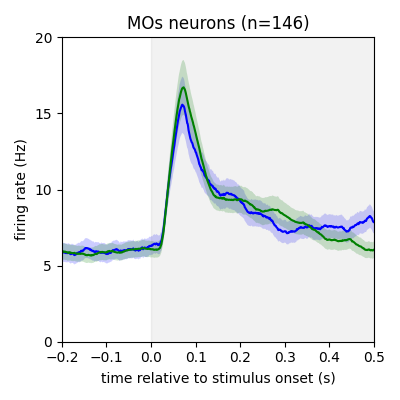

In [140]:
fig,ax=plt.subplots(1,1,figsize=(4,4))

stim_rect=patches.Rectangle([0,-5],0.5,50,color='grey',alpha=0.1)
ax.add_patch(stim_rect)

y=cr_resp_smooth_mean
err=cr_resp_smooth_sem
ax.plot(cr_resp.time, y, 'b')
plt.fill_between(cr_resp.time, y-err, y+err,
    alpha=0.2, edgecolor=None, facecolor='b')

y=hit_resp_smooth_mean
err=hit_resp_smooth_sem
ax.plot(hit_resp.time, y, 'g')
plt.fill_between(hit_resp.time, y-err, y+err,
    alpha=0.2, edgecolor=None, facecolor='g')

ax.set_title(sel_area+' neurons (n='+str(len(hit_resp.unit_id))+')')
ax.set_xlabel('time relative to stimulus onset (s)')
ax.set_ylabel('firing rate (Hz)')
ax.set_xlim([-0.2,0.5])
ax.set_ylim([0,20])
ax.set_yticks([0,5,10,15,20])

fig.tight_layout()

In [136]:
figpath=r'C:\Users\ethan.mcbride\OneDrive - Allen Institute\showcase_2022'
figname='VIS_units_highres.png'
# figname='control_heatmap_500ms_all.png'
plt.savefig(os.path.join(figpath,figname), dpi=600, facecolor='w', edgecolor='w',
            orientation='portrait', format='png',
            transparent=True, bbox_inches='tight', pad_inches=0.1,
            metadata=None)

In [110]:
# sg.convolve(hit_resp_smooth.sel(unit_id=20386),gwindow,mode='same')

In [111]:
# hit_resp.unit_id.values

<IPython.core.display.Javascript object>


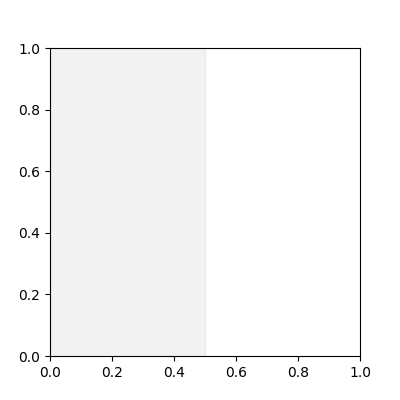

ValueError: volume and kernel should have the same dimensionality

In [137]:
gwindow = sg.gaussian(50, std=25)

# sg.convolve(fa_resp,gwindow,mode='same')/np.sum(gwindow)

fig,ax=plt.subplots(1,1,figsize=(4,4))

stim_rect=patches.Rectangle([0,-5],0.5,50,color='grey',alpha=0.1)
ax.add_patch(stim_rect)

# ax.plot(fa_resp.time,sg.convolve(fa_resp,gwindow,mode='same')/np.sum(gwindow),'m')
# ax.plot(miss_resp.time,miss_resp,'k')
ax.plot(cr_resp.time,sg.convolve(cr_resp,gwindow,mode='same')/np.sum(gwindow),'b')
ax.plot(hit_resp.time,sg.convolve(hit_resp,gwindow,mode='same')/np.sum(gwindow),'g')

ax.set_title(sel_area+' units')
ax.set_xlabel('time (s)')
ax.set_ylabel('firing rate (Hz)')
ax.set_xlim([-0.2,0.7])
ax.set_ylim([0,20])

fig.tight_layout()